# Neural Activity Model

#### Relevant Python Modules and Utility Functions

In [73]:
import numpy as np 
import math
import random as rnd
import scipy as sp
from scipy import signal
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, IntSlider
import ipywidgets as widgets
%matplotlib inline


def safe_div(nume,denom):
	''' Handles division in the case of a zero denominator. 
    
	Parameters
	----------
	nume: ND Array
		Numerator to be divided. 
	denom: ND Array
		Denominator. 

	Returns
	-------
	result: ND Array
		Result of the division.  
	'''
    
	np.seterr(divide='ignore', invalid='ignore')
	result = np.divide(nume,denom)
	result[np.isnan(result)] = 0 	# sets 0/0 = 0
	np.seterr(divide='warn', invalid='warn')

	return result


def report_progress(i,iterations,tstart):
	''' Prints to screen the model progress. 

	Parameters
	----------
	i: int 
		Current iteration of the model.

	iterations: int 
		Number of iterations set to run. 

	tstart: float 
		Time of starting the model. 
	'''
    
	progress = ((i+1)*100)/iterations
	t = time.time()
	tpassed = (t-tstart)/60
	time2go = ((tpassed/progress)*100) - tpassed

	sys.stdout.write('\r' + "{0:.3f}".format(progress) + 
                     "% completed.  Time passed: {0:.3f} mins.".format(tpassed) +  
                     "   Expected time left: {0:.3f} mins. ".format(time2go) )
	sys.stdout.flush()
    
    
def gen_pairs():
	''' Generates all possible pairs of adjacent retinal neurons. 

	Returns
	-------
	pairs: 2D Array
		Takes format pairs[pair_num,:] = [i1,j1,i2,j2] where i1,i2 and j1,j2 are
		retinal coordinates in the nasal-temporal and dorsal-ventral axes
		respectively. 
	'''    
    
	idim = RET_DIM_1
	jdim = RET_DIM_2
    
	num_pairs = 2*(idim-1)*(jdim-1) + (idim-1) + (jdim-1)
	pairs = np.zeros((num_pairs,4))
	count = 0
    
	for i in range(RET_DIM_1):
		for j in range(RET_DIM_2):
            
			if(i!=RET_DIM_1-1):
				pairs[count,:] = [i,j,i+1,j]
				count+=1
                
			if(j!=RET_DIM_2-1):
				pairs[count,:] = [i,j,i,j+1]
				count+=1

	return (num_pairs,pairs.astype(int))


def get_tec_pm():
    ''' Obtains coordinates of middle 4 tectal cells. 
    
    Returns
    -------
    pms: 1D Array
        k,l coordinates of middle 4 tectal neurons. 
    '''
    kmid1 = (TEC_DIM_1//2) - 1
    kmid2 = kmid1+1

    lmid1 = (TEC_DIM_2//2) - 1
    lmid2 = lmid1 + 1
    
    pms = [[kmid1,lmid1],[kmid1,lmid2],[kmid2,lmid1],[kmid2,lmid2]]

    return pms


def reset_sheet_params(ret1,ret2,tec1,tec2):
    global RET_DIM_1, RET_DIM_2, TEC_DIM_1, TEC_DIM_2, TEC_PM

    RET_DIM_1 = ret1
    RET_DIM_2 = ret2
    TEC_DIM_1 = tec1
    TEC_DIM_2 = tec2
    TEC_PM = get_tec_pm()
    

### Model Parameters

In [14]:
dt = 1
FRAME_RATE = 500

RET_DIM_1 = 6
RET_DIM_2 = 6
TEC_DIM_1 = 6
TEC_DIM_2 = 6

POLARITY_MULT = 5
ACTIVITY_THRESH = 10								# theta
MEM_TIME_CONST = 0.5								# alpha
STATIONARITY_CONST = 0.005

INIT_SYN_MEAN = 2.5									# S
INIT_SYN_SD = 0.14
SYN_MOD_THRESH = 2									# epsilon
HEBB_CONST = 0.0016									# h

beta = 0.05
gamma = 0.025
delta = -0.06

DIST_FILTER = np.array([[0, 0, 0, delta, 0, 0, 0],
					[0, 0, delta, gamma, delta, 0, 0],
				[0, delta, gamma, beta, gamma, delta, 0],
				[delta, gamma, beta, 0, beta, gamma, delta],
					[0, delta, gamma, beta, gamma, delta, 0],
					[0, 0, delta, gamma, delta, 0, 0],
						[0, 0, 0, delta, 0, 0, 0]])

TEC_PM = get_tec_pm() #middle 4 neurons by default

## Model Procedure

#### 1. Initialise Synaptic Weights

In [15]:
def init_syns():
	''' Initialises synaptic weights according to a normal distribution.
	Polarity markers are added to the middle 4 cells of each sheet.

	Returns
	--------
	syn_weights: 4D Array
		Synaptic weights of connections between each retinal and tectal neuron.
	'''
    
	syn_weights = np.random.normal(INIT_SYN_MEAN,INIT_SYN_SD,
		(RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))

	imid1 = (RET_DIM_1//2) - 1
	imid2 = imid1 + 1

	jmid1 = (RET_DIM_2//2)-1
	jmid2 = jmid1+1

	[[k0,l0],[k1,l1],[k2,l2],[k3,l3]] = TEC_PM

	syn_weights[imid1,jmid1,k0,l0] *= POLARITY_MULT
	syn_weights[imid1,jmid2,k1,l1] *= POLARITY_MULT
	syn_weights[imid2,jmid1,k2,l2] *= POLARITY_MULT
	syn_weights[imid2,jmid2,k3,l3] *= POLARITY_MULT

	syn_weights = norm_syns(syn_weights)

	return syn_weights

#### 2. Activate Adjacent Retinal Cells

In [16]:
def activate_ret(pairs,num_pairs):
    ''' Chooses a random pair of adjacent retinal neurons to activate.
    
    Parameters
    ----------
    pairs: 2D Array
        i,j coordinates of all adjacent pairs of retinal neurons. 
        Takes the form pairs[pair_num,:] = [i1,j1,i2,j2].
    num_pairs: int 
        Number of distinct adjacent pairs of retinal neurons.
        
    Returns
    -------
    pair: 1D Array
        i,j coordinates of the chosen pair of retinal neurons. 
    '''
    pair = pairs[np.random.choice(num_pairs),:]
    return pair

#### 3. Depolarise Tectal Cells

In [17]:
def activate_tec(syn_weights,pair):
	''' Computes linear sum of activated retinal neurons and their
	synaptic weights. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	pair: 1D Array 
		x,y, coordinates of activated retinal neurons. 

	Returns
	-------
	mem_pot: 2D Array 
		Excitation of each tectal neuron as a result of activated retinal
		neurons. 

	'''

	[i1,j1,i2,j2] = pair
	mem_pot = syn_weights[i1,j1,:,:] + syn_weights[i2,j2,:,:]

	return mem_pot

#### 4. Threshold Tectal Depolarisation

In [18]:
def thresh(cur_pot):
	''' Applies threshold to tectal membrane potentials. 

	Returns
	-------
	mem_pot: 2D Array
		Post-threshold activity of each tectal neuron. 
	'''
	cur_pot[cur_pot < ACTIVITY_THRESH] = 0
	cur_pot[cur_pot > ACTIVITY_THRESH] -= ACTIVITY_THRESH 

	return cur_pot

#### 5. Apply tectal excitation/inhibition

In [19]:
def tec_feedback(activity):
	''' Computes excitation and inhibition effects from neighbouring tectal
	neurons. 

	Parameters
	----------
	activity: 2D array
		Post-threshold potential of each tectal neuron. 

	Returns
	-------
	feedback: 2D Array 
		Convolution of tectal activity with a Manhatten distance filter. 
		Represents contributions of neighbouring tectal neurons to 
		membrane potential. 
	'''

	feedback = sp.signal.convolve2d(activity, DIST_FILTER, 
		mode='same', boundary='fill', fillvalue=0)

	return feedback

#### 6. Update membrane potentials

In [20]:
def update_potential(syn_weights,init_pot):
	''' Simulates differential equations, using Euler's method, to update
	tectal membrane potentials (see Willshaw, von der Malsburg, 1976). 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	init_pot: 2D Array 
		Excitation of each tectal neuron provided by activated retinal neurons. 

	Returns
	-------
	activity: 2D Array
		Updated post-threshold potentials of each tectal neuron. 
	'''
    
	cur_pot = init_pot.copy()
	mean_change = 1
	new_mean = np.mean(cur_pot)
	old_mean = 0

	while(mean_change > STATIONARITY_CONST*old_mean):
		old_mean = new_mean
		activity = thresh(cur_pot.copy())
		conv = tec_feedback(activity)
		pot_change = (init_pot + conv) - (MEM_TIME_CONST*cur_pot) 
		cur_pot += pot_change*dt
		new_mean = np.mean(cur_pot)
		mean_change = abs(new_mean-old_mean)

	activity = thresh(cur_pot)

	return activity

#### 7. Apply Hebbian learning rule

In [21]:
def update_syns(syn_weights,activity,pair):
	''' Applies Hebbian learning rule to connections between activated 
	retinal neurons and strongly excitated tectal neurons. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	activity: 2D Array
		Post-threshold potential of each tectal neuron. 

	pair: 1D Array 
		Coordinates of activated retinal neurons. Takes format [i1,j1,i2,j2].

	Returns
	-------
	syn_weights: 4D Array 
		Updated synaptic weights between each retinal and tectal neuron. 
	'''

	[i1,j1,i2,j2] = pair

	inds = np.where(activity > SYN_MOD_THRESH)

	if(np.any(inds)!=0):
		(indsx,indsy) = inds
		syn_weights[i1,j1,indsx,indsy] += HEBB_CONST*activity[inds]
		syn_weights[i2,j2,indsx,indsy] += HEBB_CONST*activity[inds]

	syn_weights = norm_syns(syn_weights)

	return syn_weights

#### 8. Normalise synaptic weights

In [22]:
def norm_syns(syn_weights):
	''' Normalises the synaptic weights so that the mean weight 
	contacting each tectal neuron remains constant. 

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	Returns
	-------
	syn_weights: 4D Array
		Normalised synaptic weights. 
	'''
    
	reshaped_weights = np.reshape(syn_weights,(RET_DIM_1*RET_DIM_2,
		TEC_DIM_1*TEC_DIM_2))

	mu = np.mean(reshaped_weights,axis=0)
	norm_weights = np.divide(reshaped_weights*INIT_SYN_MEAN,mu)

	syn_weights = np.reshape(norm_weights,(RET_DIM_1,RET_DIM_2,
		TEC_DIM_1,TEC_DIM_2))

	return syn_weights

## Determining tectal receptive fields

In [87]:
def calc_rf_centres(syn_weights):
	''' Computes retinal coordinates for the receptive field centre of each
	tectal neuron. For each tectal neuron, the coordinates of the receptive
	field centre is calculated as a sum over all retinal positions 
	weighted by the corresponding synatpic weights. The weighted
	sum is then normalised by dividing over the sum of synaptic weights 
	arriving at the tectal neuron being considered.  

	Parameters
	----------
	syn_weights: 4D Array 
		Synaptic weights of each connection between retinal and tectal neurons.

	Returns
	-------
	rec_field: 3D Array 
		i,j coordinates of the centre of the receptive field for each 
		tectal neuron. Takes format rec_field[k,l,:] = [i,j].
	'''

	rec_field = np.zeros((TEC_DIM_1,TEC_DIM_2,2))
    
	# reshape for vectorisation
	rshpe_syns = np.reshape(syn_weights,(RET_DIM_1*RET_DIM_2,
		TEC_DIM_1*TEC_DIM_2))
	denom = np.sum(rshpe_syns,axis=0)

	# i coordinate
	iinds = np.matrix(np.repeat([i for i in range(0,RET_DIM_1)],RET_DIM_2)).T
	inume = np.sum(np.multiply(rshpe_syns,iinds),axis=0)
	rshpe_irf = np.divide(inume,denom)
	irf = np.reshape(rshpe_irf,(TEC_DIM_1,TEC_DIM_2))

	# j coordinate
	jinds = np.matrix(np.tile([j for j in range(0,RET_DIM_2)],RET_DIM_1)).T
	jnume = np.sum(np.multiply(rshpe_syns,jinds),axis=0)
	rshpe_jrf = np.divide(jnume,denom)
	jrf = np.reshape(rshpe_jrf,(TEC_DIM_1,TEC_DIM_2))

	rec_field[:,:,0] = irf
	rec_field[:,:,1] = jrf

	return rec_field

## Running Model Simulation

In [68]:
def run(iterations):
	""" Runs simulation of Activity Model.

	A simulation cycle consists of:
	1) Exciting a pair of retinal neurons at random.
	2) Computing the subseqent activation in the tectum.
	3) Simulating tectal interactions.
	4) Updating synaptic weights. 

	Parameters
	----------
	iterations: Number of iterations to iterate simulation cycle. 
    
	Returns
	-------
 	iter_weights: 5D Array
        The synaptic weights between each neuron in the retina and tectum at each
        saved iteration. Takes format iter_weights[iteration,i,j,k,l]. 
    
    rf_centres: 4D Array
        Contains the i,j coordinates of the receptive field centres of each tectal
        neuron at each saved iteration. Takes format rf_centres[iteration,k,l,:] = [i,j] 
        where k,l are tectal coordinates. 
	"""
    
	print("Running Neural Activity Model...")

	tstart = time.time()
	syn_weights = init_syns()
	(num_pairs,pairs) = gen_pairs()
    
	iter_weights = np.zeros((math.floor(iterations/FRAME_RATE),
				RET_DIM_1,RET_DIM_2,TEC_DIM_1,TEC_DIM_2))
	rf_centres = np.zeros((math.floor(iterations/FRAME_RATE),
		TEC_DIM_1,TEC_DIM_2,2))

	for i in range(iterations):
		pair = activate_ret(pairs,num_pairs)
		init_pot = activate_tec(syn_weights,pair)
		activity = update_potential(syn_weights,init_pot)
		syn_weights = update_syns(syn_weights,activity,pair)
		syn_weights = norm_syns(syn_weights)
		
		if(i%FRAME_RATE == 0):
			index = math.floor(i/FRAME_RATE)
			iter_weights[index,:,:,:,:] = syn_weights
			rf_centres[index,:,:,:] = calc_rf_centres(syn_weights)
		report_progress(i,iterations,tstart)

	return (iter_weights,rf_centres)

In [89]:
reset_sheet_params(6,6,6,6)
(iter_weights,rf_centres) = run(60000)

Running Neural Activity Model...
100.000% completed.  Time passed: 1.736 mins.   Expected time left: 0.000 mins. 

## Visualising Retinotopic Map

In [70]:
def plot_iteration(iteration):
	''' Plots a lattice plot representing the receptive fields of 
	each tectal neuron at a given iteration of the model simulation. 

	Parameters
	----------
	iteration: int 
		Iteration of model simulation to display receptive fields. 
	'''
    
	rec_fields = rf_centres[iteration]

	# Draws lines between posterior-anterior tectal neighbours 
	for k in range(TEC_DIM_1):
		i1 = []
		j1 = []
		for l in range(TEC_DIM_2):
			i1.append(rec_fields[k,l,0])
			j1.append(rec_fields[k,l,1])

		plt.plot(i1,j1,c='k')

	# Draws lines between lateral-medial tectal neighbours
	for l in range(TEC_DIM_2):
		i2 = []
		j2 = []
		for k in range(TEC_DIM_1):
			i2.append(rec_fields[k,l,0])
			j2.append(rec_fields[k,l,1])
		plt.plot(i2,j2,c='k')
        
	plt.show()

    
def update(val):
	''' Updates lattice plot with updated iteration value from slider.

	Parameters
	----------
	val: int 
		Iteration number passed from slider. Value is divided by the 
		FRAME_RATE to obtain the corresponding index in the array containing
		saved receptive fields. 
	'''
    
	val = int(np.floor(val/FRAME_RATE))
	plt.xlim(0,RET_DIM_1-1)
	plt.ylim(0,RET_DIM_2-1)
	plt.xlabel('Nasal-Temporal Position')
	plt.ylabel('Dorsal-Vental Position')
	plt.axes().set_aspect('equal')
	plot_iteration(val)

    
def plot_map(rfs):
    ''' Sets up lattice plot figure with slider control. 

    Parameters
    ----------
    rfs: 4D Array
        Contains the i,j coordinates of the receptive field centres of each tectal
        neuron at each saved iteration. Takes format rfs[iteration,k,l,:] = [i,j] 
        where k,l are tectal coordinates. 
    '''
    
    global rf_centres
    rf_centres = rfs
    fig = plt.figure()
    update(0)
    
    interact(update,val=IntSlider(min=0,
    max=(len(rf_centres[:,0,0,0])-1)*FRAME_RATE -1,
    step=1,description="Iteration: "))

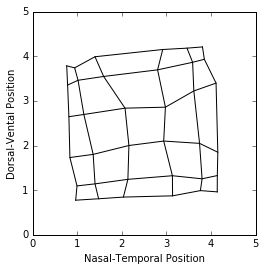

In [90]:
reset_sheet_params(6,6,6,6)
plot_map(rf_centres)

## Systems Matching

In [83]:
def systems_matching(ret1,ret2,tec1,tec2,iterations):
    ''' Runs model simulation with different sheet sizes. '''

    reset_sheet_params(ret1,ret2,tec1,tec2)
    (iter_weights,rf_centres) = run(iterations)
    return (iter_weights,rf_centres)

### 5x5 |  5x7

In [53]:
(iw1,rfc1) = systems_matching(5,5,5,7,60000)

Running Neural Activity Model...
100.000% completed.  Time passed: 1.748 mins.   Expected time left: 0.000 mins. 

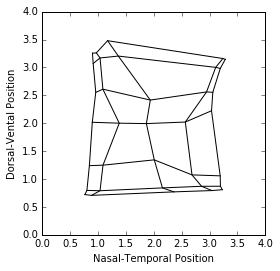

In [77]:
reset_sheet_params(5,5,5,7)
plot_map(rfc1)

### 6x6 | 4x4

In [34]:
(iw2,rfc2) = systems_matching(6,6,4,4,60000)

Running Neural Activity Model...
100.000% completed.  Time passed: 1.757 mins.   Expected time left: 0.000 mins. 

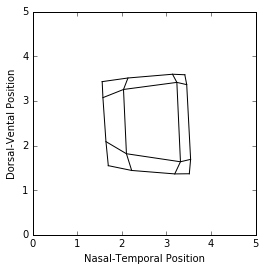

In [78]:
reset_sheet_params(6,6,4,4)
plot_map(rfc2)

### 5x5 | 4x6

In [36]:
(iw3,rfc3) = systems_matching(5,5,4,6,60000)

Running Neural Activity Model...
100.000% completed.  Time passed: 1.778 mins.   Expected time left: 0.000 mins. 

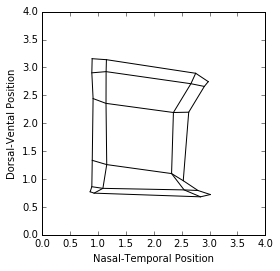

In [79]:
reset_sheet_params(5,5,4,6)
plot_map(rfc3)   

## Changing Polarity

In [57]:
def change_polarity(perm,iterations):
    ''' Modifies the tectal polarity markers to change the orientation
    of the formed map. 
    
    Parameters
    ----------
    perm: 1D Array
        The permutation to apply to the tectal polarity markers. i.e. for a
        4x4 grid of retina polarity markers labelled [0,1,2,3], connect each marker
        to the corresponding position in the tectal 4x4 grid indicated by perm. 
        
        e.g. perm = [1,3,0,2] defines a 90 degree clockwise rotation. 
        perm[0] = 1 so, the retinal neuron in position 0 is mapped to 
        tectal position 1 and so on...

        |0|1| -> |2|0|
        |2|3|    |3|1|
        
    iterations: int 
        Number of iterations to run the simulation with the permuted 
        polarity markers. 
        
    Returns
    -------
    iter_weights: 5D Array
        The synaptic weights between each neuron in the retina and tectum at each
        saved iteration. Takes format iter_weights[iteration,i,j,k,l]. 
    
    rf_centres: 4D Array
        Contains the i,j coordinates of the receptive field centres of each tectal
        neuron at each saved iteration. Takes format rf_centres[iteration,k,l,:] = [i,j] 
        where k,l are tectal coordinates. 
    '''
    
    global RET_DIM_1, RET_DIM_2, TEC_DIM_1, TEC_DIM_2, TEC_PM
    RET_DIM_1 = 5
    RET_DIM_2 = 5
    TEC_DIM_1 = 4
    TEC_DIM_2 = 6
    TEC_PM = get_tec_pm()

    copy = TEC_PM.copy()
    for n in range(4):
        TEC_PM[n] = copy[perm[n]]
        
    print("New polarity markers:")
    print("0 -> " + str(perm[0]))
    print("1 -> " + str(perm[1]))
    print("2 -> " + str(perm[2]))
    print("3 -> " + str(perm[3]) + "\n")
    (iter_weights,rf_centres) = run(iterations)
    TEC_PM = copy #resets
    return (iter_weights,rf_centres)

### Rotation

In [65]:
(iw4,rfc4) = change_polarity([1,3,0,2],60000)

New polarity markers:
0 -> 1
1 -> 3
2 -> 0
3 -> 2

Running Neural Activity Model...
100.000% completed.  Time passed: 1.776 mins.   Expected time left: 0.000 mins. 

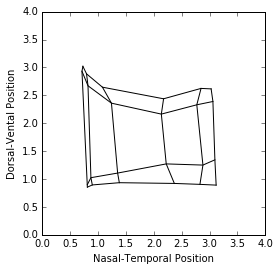

In [80]:
reset_sheet_params(5,5,4,6)
plot_map(rfc4)

### Twist

In [63]:
(iw5,rfc5) = change_polarity([0,3,2,1],60000)

New polarity markers:
0 -> 0
1 -> 3
2 -> 2
3 -> 1

Running Neural Activity Model...
100.000% completed.  Time passed: 1.804 mins.   Expected time left: 0.000 mins. 

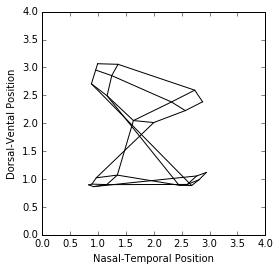

In [81]:
reset_sheet_params(5,5,4,6)
plot_map(rfc5)